In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
print(train.shape,test.shape)

(8693, 14) (4277, 13)


In [3]:
print(f'Total null values in train = {train.isna().sum().sum()}')
print(train.isna().sum())
print('-'*30)
print(f'Total null values in test = {test.isna().sum().sum()}')
print(test.isna().sum())

Total null values in train = 2324
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
------------------------------
Total null values in test = 1117
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


* **PassengerId** has no missing values in train and test set. Test set has no Transported column
* Rest all columns has missing values

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


1. Age column seems to be normally distributed . Also very less outliers are present in Age(mean and 50% are very close)
2. Rest all the other columns has outliers. Seems like most of the values are 0 in  RoomService,FoodCourt,ShoppingMall,Spa,VRDeck .

From here onwards I will perform EDA on train set(since I have to train my model on this set). And join **train and test set(total)** together so that preprocessing becomes easier.

In [6]:
# merging train and test so that cleaning and preprocessing gets easier
y = train['Transported']
# total = pd.concat([train.drop('Transported',axis=1),test],axis=0)
total = pd.concat([train,test],axis=0)
print(total.shape)
total.head()

(12970, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.

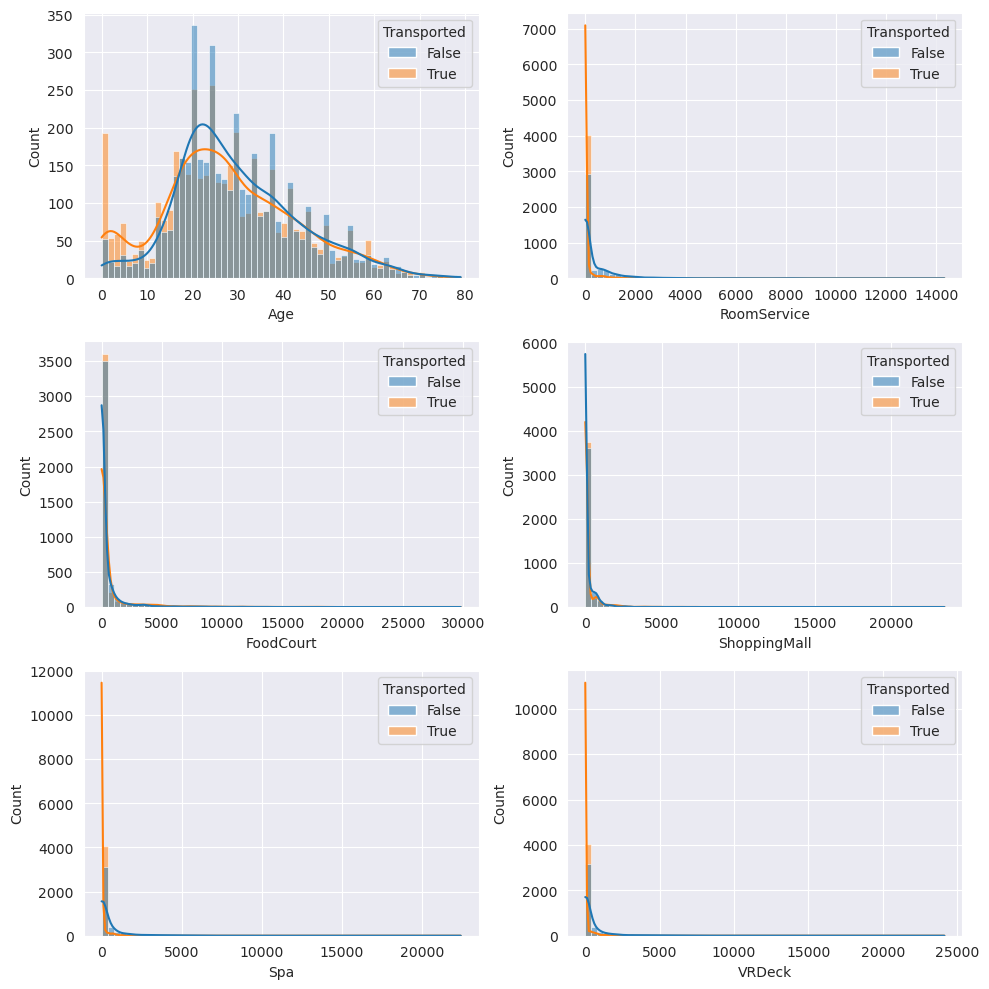

In [7]:
# checking the distribution of exprenditure variables
num_vars = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

fig = plt.figure(figsize=(10,10))
#  plot Numerical Data
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter


for idx,col in enumerate(num_vars):
    plt.subplot(a, b, c)
    plt.xlabel(col)
    sns.histplot(data = train, x = col,bins=60, hue ='Transported',kde=True)
    c = c + 1
    
plt.tight_layout()
plt.show()

1. Expenditure variables like 'RoomService','FoodCourt','ShoppingMall','Spa','VRDeck' are highly positive skewed.
2. In age distribution, 0-18 years has more probabiltiy of Transported than not. 19-25 years were less likely to be transported. After 25 years there is equal chances to be transported.

Insights:
* Make a new feature to track the total expenses by an individual (From expenses columns)
* Make a new feature to indicate weather an individual is a child,adolescent  or adult (From age column)
* Create a new column to check if a person has spent anything or not (From expenses columns)

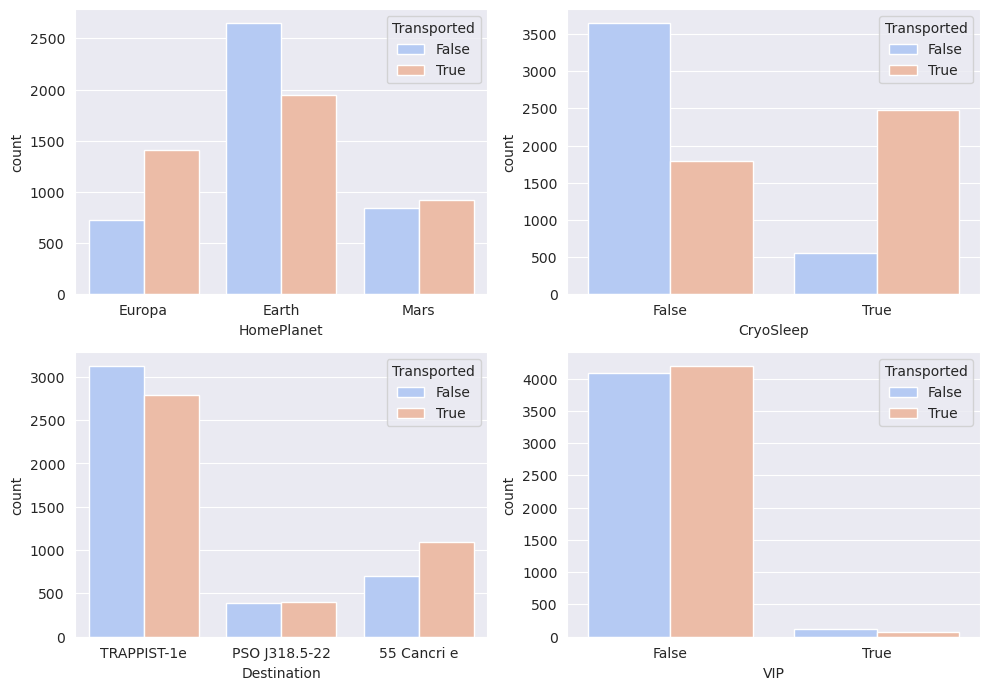

In [8]:
# checking categorical features distribution

cat_vars = ['HomePlanet','CryoSleep','Destination','VIP']

fig = plt.figure(figsize=(10,10))
#  plot Numerical Data
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter


for idx,col in enumerate(cat_vars):
    plt.subplot(a, b, c)
    plt.xlabel(col)
    sns.countplot(data = train, x = col,hue ='Transported',palette='coolwarm')
    c = c + 1
    
plt.tight_layout()
plt.show()

1. Most people are from Home Planet Earth.
2. Most people choose Destination as TRAPPIST-1e
3. Most people choose not be in cryoSleep
4. VIP feature does not seem to be useful here as target distribution is more or less same

Insights

* We might consider dropping the VIP column to prevent overfitting

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. 

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Name** - The first and last names of the passenger.

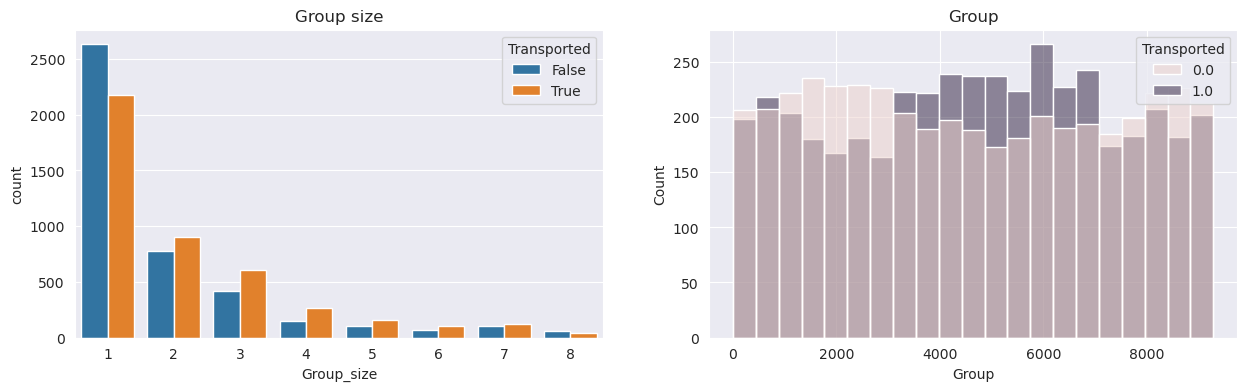

In [9]:
# extracting group and group size from Passenger_Id 
total['Group'] = total['PassengerId'].map(lambda x: x.split('_')[0]).astype(int)
total['Group_size'] = total['Group'].map(lambda x: total['Group'].value_counts()[x])

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.countplot(data = total,x = 'Group_size',hue='Transported')
plt.title('Group size')

plt.subplot(1,2,2)
sns.histplot(data = total,x = 'Group',hue='Transported')
plt.title('Group')

plt.show()

1. We cannot use the group feature because in doing one-hot encoding it would explode the number of dimensions.
2. Group size is useful. When group size <= 1 then the person has less chances to be transported.

Insights
* We can make a new feature(from Group_size feature) to show if a person is travelling solo or not

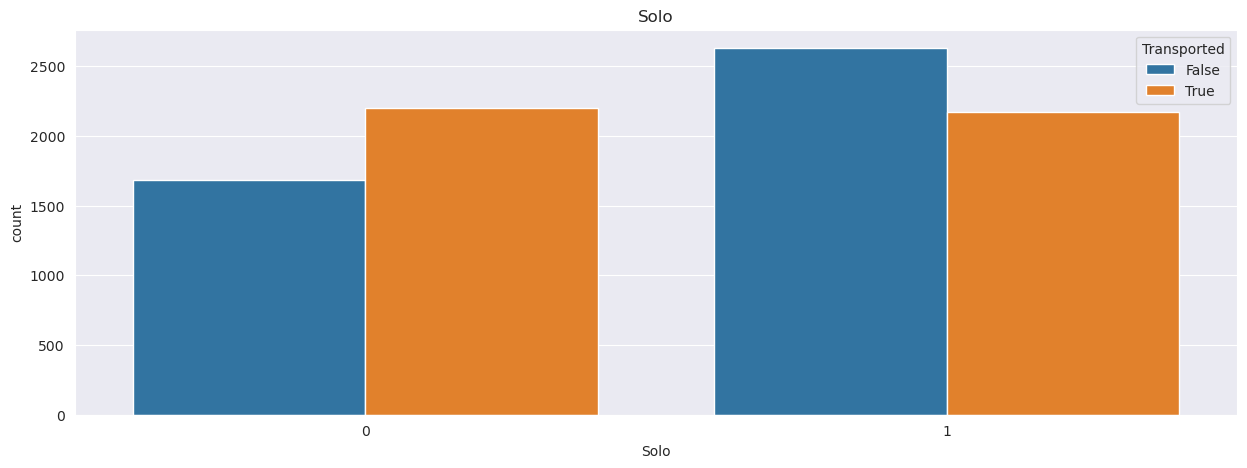

In [10]:
total['Solo'] = total['Group_size'].apply(lambda x: 1 if x==1 else 0).astype(int)

fig = plt.figure(figsize=(15,5))
sns.countplot(data = total,x = 'Solo',hue='Transported')
plt.title('Solo')
plt.show()

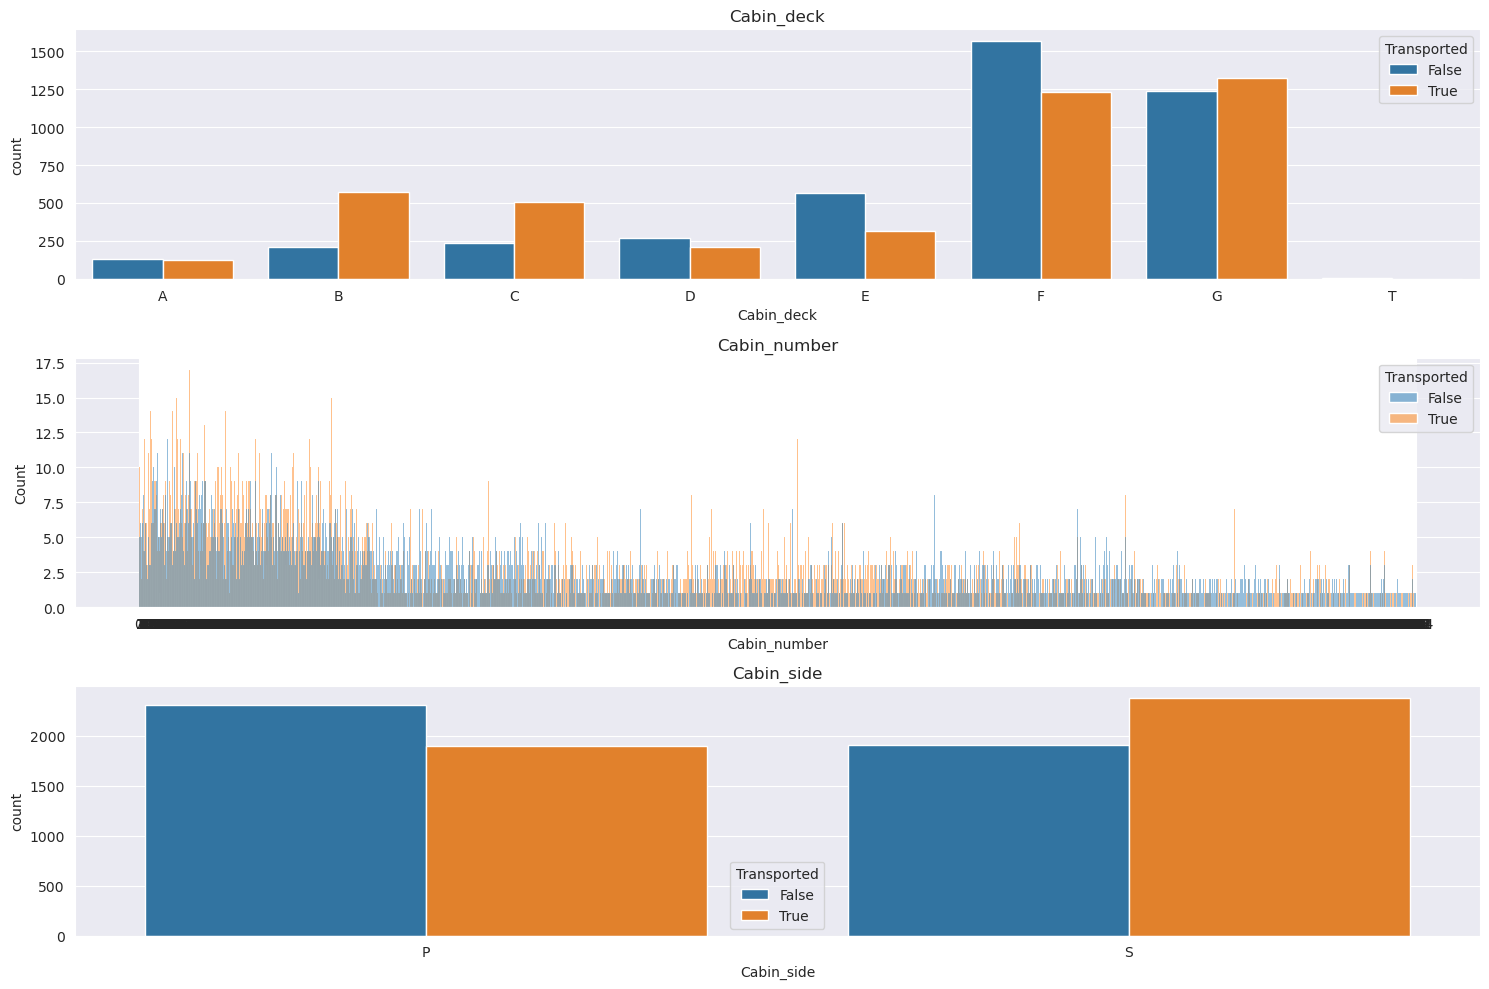

In [11]:
# extracting cabin deck , cabin number , cabin side from cabin 
total['Cabin_deck'] = total['Cabin'].map(lambda x: x.split('/')[0] if isinstance(x,float)==False else np.nan)
total['Cabin_number'] = total['Cabin'].map(lambda x: x.split('/')[1] if isinstance(x,float)==False else np.nan)
total['Cabin_side'] = total['Cabin'].map(lambda x: x.split('/')[2] if isinstance(x,float)==False else np.nan)


fig = plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
sns.countplot(data = total,x = 'Cabin_deck',hue='Transported',order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin_deck')

plt.subplot(3,1,2)
sns.histplot(data = total.dropna(subset=['Transported'],axis=0),x = 'Cabin_number',hue='Transported')
plt.title('Cabin_number')

plt.subplot(3,1,3)
sns.countplot(data = total,x = 'Cabin_side',hue='Transported')
plt.title('Cabin_side')

fig.tight_layout()
plt.show()

*  Cabin deck T is an outlier(only 7 decks are there)

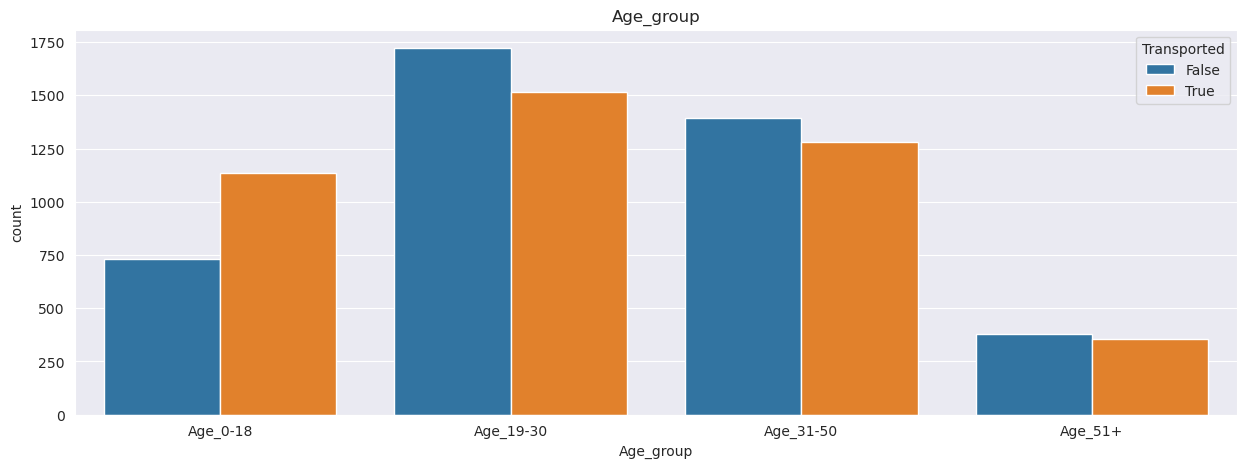

In [12]:
# new feature Age_group from Age
total['Age_group'] = np.nan
total.loc[(total['Age']<=18),'Age_group'] = 'Age_0-18'
total.loc[(total['Age']>18) & (total['Age']<=30),'Age_group'] = 'Age_19-30'
total.loc[(total['Age']>30) & (total['Age']<=50),'Age_group'] = 'Age_31-50'
total.loc[(total['Age']>50),'Age_group'] = 'Age_51+'


fig = plt.figure(figsize=(15,5))
sns.countplot(data = total,x = 'Age_group',hue='Transported',order=['Age_0-18','Age_19-30', 'Age_31-50','Age_51+'])
plt.title('Age_group')
plt.show()

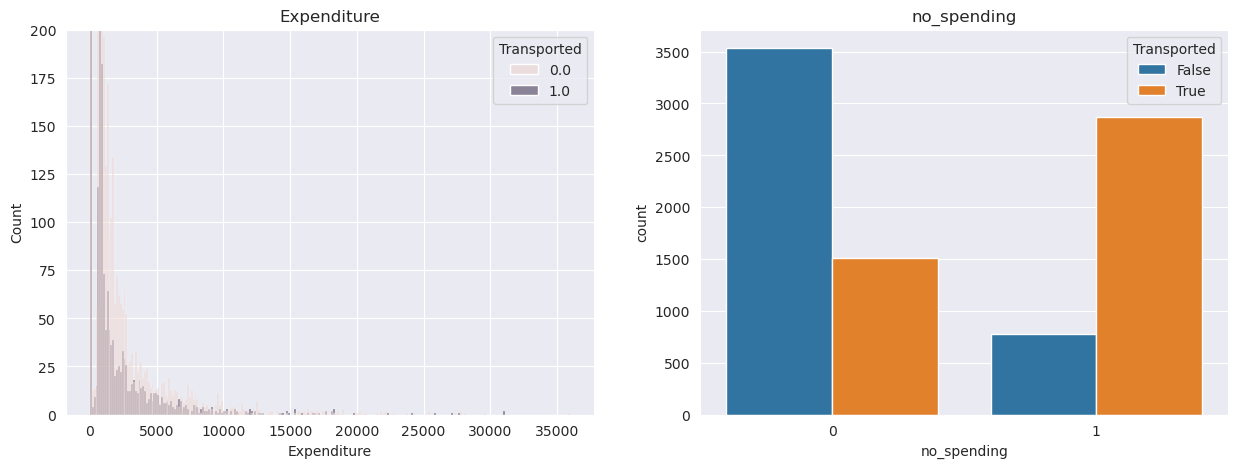

In [13]:
# new feature Expenditure from RoomService, FoodCourt , ShoppingMall , Spa , VRDeck
total['Expenditure'] = total[['RoomService', 'FoodCourt' , 'ShoppingMall' , 'Spa' , 'VRDeck']].sum(axis=1)

# new feature no_spending from Expenditure
total['no_spending'] = (total['Expenditure']==0).astype(int)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data = total,x = 'Expenditure',hue='Transported')
plt.ylim([0,200])
plt.title('Expenditure')

plt.subplot(1,2,2)
sns.countplot(data = total,x = 'no_spending',hue='Transported')
plt.title('no_spending')

plt.show()

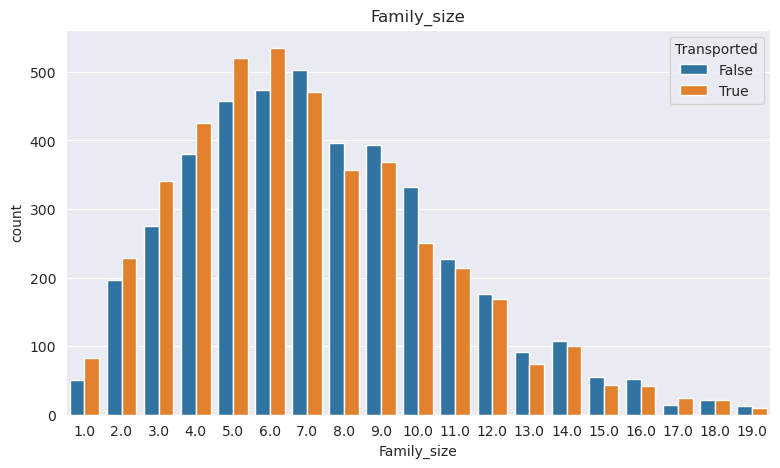

In [14]:
# new feature Surname,Family size from 'Name'
total['Surname'] = total['Name'].str.split().str[-1]
total['Family_size'] = total['Surname'].map(lambda x: total['Surname'].value_counts()[x] if isinstance(x,float)==False else np.nan)

fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(data = total,x = 'Family_size',hue='Transported')
plt.title('Family_size')
plt.show()

## Handling missing values

In [15]:
y = train['Transported'].copy().astype(int)
total.drop(['Transported'],axis=1,inplace=True)

In [16]:
na_cols = total.columns[total.isna().any()].tolist()

missing_values_df = pd.DataFrame(data=total[na_cols].isna().sum(),columns=['Missing values'])
missing_values_df['Percent_missing'] = np.round(missing_values_df['Missing values']/total.shape[0]*100 , 2)
missing_values_df

,Missing values,Percent_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Cabin,299,2.31
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19


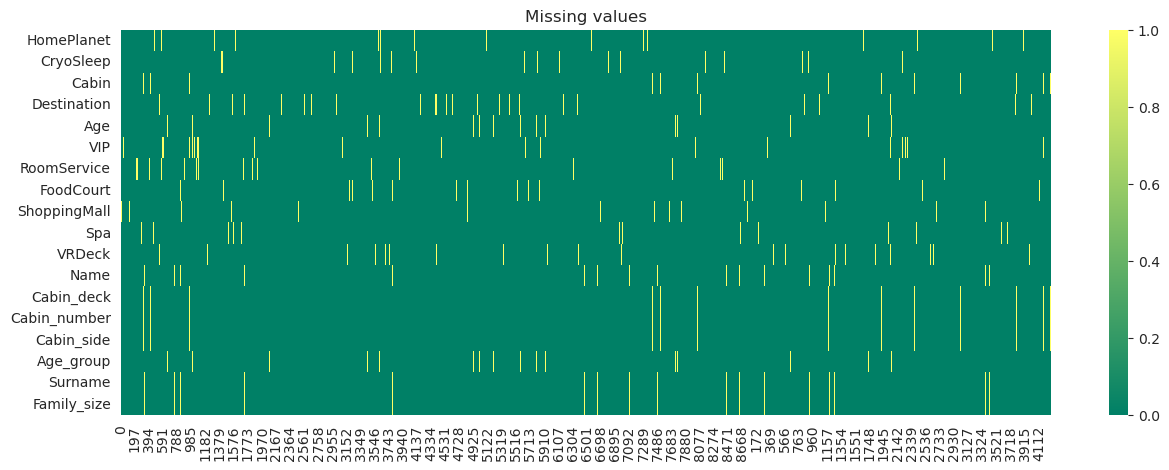

In [17]:
# Heatmap of missing values
plt.figure(figsize=(15,5))
sns.heatmap(total[na_cols].isna().T,cmap='summer')
plt.title('Missing values')
plt.show()

Except for (Cabin deck, cabin number , cabin side) and (Surname, Family size),rest of the missing values does not seem to happen at same time.

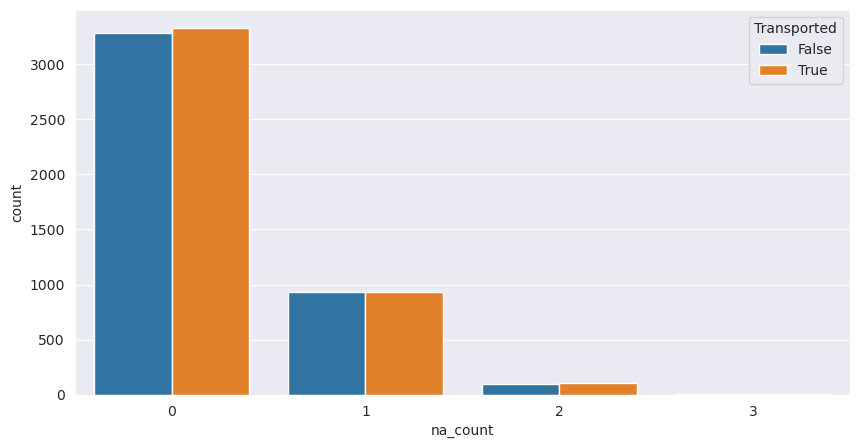

In [18]:
# count the missing values by passenger
train['na_count'] = train.isna().sum(axis=1)

plt.figure(figsize=(10,5))
sns.countplot(data=train,x='na_count',hue='Transported')
plt.show()

train.drop('na_count',axis=1,inplace=True)

* Missing values are independent of target class

In [19]:
total.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Group', 'Group_size', 'Solo', 'Cabin_deck', 'Cabin_number',
       'Cabin_side', 'Age_group', 'Expenditure', 'no_spending', 'Surname',
       'Family_size'],
      dtype='object')

In [20]:
# Filling missing values in Home Planet

# Group and Home Planet joint distribution
GHP_gb = total.groupby(['Group','HomePlanet']).size().unstack().fillna(0)
GHP_gb['Sum'] = (GHP_gb>0).sum(axis=1)
GHP_gb['Sum'].value_counts()

1    9124
Name: Sum, dtype: int64

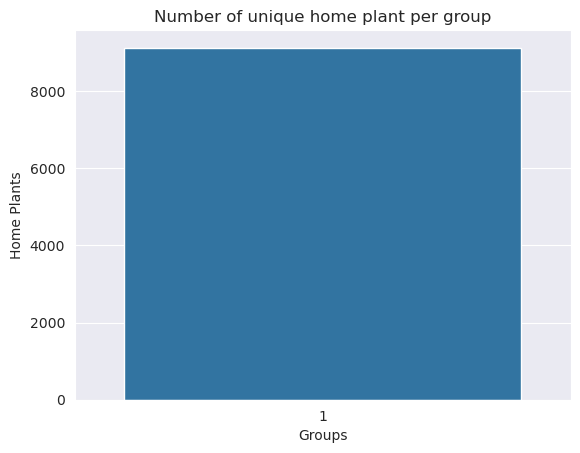

In [21]:
sns.barplot( data=GHP_gb, x = GHP_gb['Sum'].value_counts().index,y=GHP_gb['Sum'].value_counts())
plt.title('Number of unique home plant per group')
plt.xlabel('Groups')
plt.ylabel('Home Plants')
plt.show()

GHP_gb.drop('Sum',axis=1,inplace=True)

* This shows that everyone from the same group comes from the same home planet. So group can be used to fill in the missing values in Home Planet.

In [22]:
HP_bef = total['HomePlanet'].isna().sum()

# Idea - A person who has missing HomePlant but he/she is part of a group whose HomePlant is known. We identify these rows by GHP_index
GHP_index = total[total['HomePlanet'].isna()][total[total['HomePlanet'].isna()]['Group'].isin(GHP_gb.index)].index

# select the Group from 'GHP_index' to find the HomePlanet
total.loc[GHP_index,'HomePlanet'] = total.loc[GHP_index,'Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',total['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


In [23]:
#  Using HomePlant and Cabin Deck joint distribution to fill missing values

CDHP_gb = total.groupby(['Cabin_deck','HomePlanet']).size().unstack().fillna(0)
CDHP_gb

HomePlanet,Earth,Europa,Mars
Cabin_deck,,,
A,0.0,352.0,0.0
B,0.0,1137.0,0.0
C,0.0,1096.0,0.0
D,0.0,301.0,410.0
E,589.0,199.0,515.0
F,2437.0,0.0,1742.0
G,3731.0,0.0,0.0
T,0.0,10.0,0.0


* On deck A, B , C , T only passengers coming from Eupora are found 
* On deck G only passengers coming from Earth are found
* On deck D, E, F passengers from multiple planets are found

In [24]:
HP_bef = total.HomePlanet.isna().sum()

# On deck A, B , C , T only passengers coming from Eupora are found
total.loc[(total['HomePlanet'].isna()) & (total.Cabin_deck.isin(['A','B','C','T'])),'HomePlanet'] = 'Europa'

# On deck G only passengers coming from Earth are found
total.loc[(total['HomePlanet'].isna()) & (total['Cabin_deck']=='G'),'HomePlanet'] = 'Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',total['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


In [25]:
#  Using HomePlant and Surname joint distribution to fill missing values

SHP_gb = total.groupby(['Surname','HomePlanet']).size().unstack().fillna(0)
SHP_gb

HomePlanet,Earth,Europa,Mars
Surname,,,
Acobson,5.0,0.0,0.0
Acobsond,8.0,0.0,0.0
Adavisons,10.0,0.0,0.0
Adkinson,4.0,0.0,0.0
Admingried,0.0,4.0,0.0
...,...,...,...
Wynneyerson,2.0,0.0,0.0
Yanton,8.0,0.0,0.0
Yatters,8.0,0.0,0.0


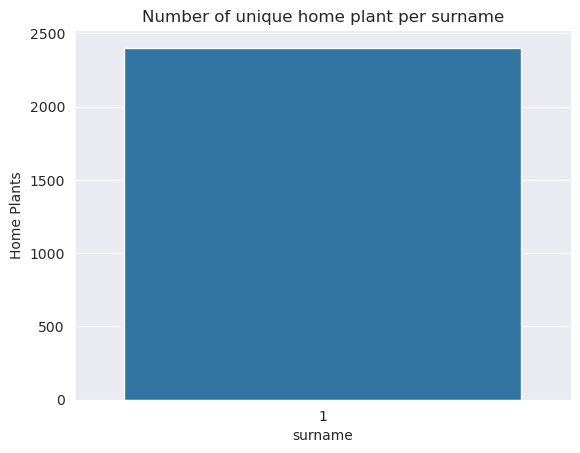

In [26]:
# check if a surname comes from a same planet
SHP_gb['Sum'] = (SHP_gb>0).sum(axis=1)
SHP_gb['Sum'].value_counts()

sns.barplot( data=SHP_gb, x = SHP_gb['Sum'].value_counts().index,y=SHP_gb['Sum'].value_counts())
plt.title('Number of unique home plant per surname')
plt.xlabel('surname')
plt.ylabel('Home Plants')
plt.show()

SHP_gb.drop('Sum',axis=1,inplace=True)

In [27]:
HP_bef = total['HomePlanet'].isna().sum()

# Idea - A person with the missing HomePlanet and belongs to a family(Surname) which has HomePlanet known. We identify these rows by SHP_gb
SHP_index = total[total['HomePlanet'].isna() & total['Surname'].isin(SHP_gb.index)].index

# select the surname from 'SHP_gb' to fill the HomePlanet
total.loc[SHP_index,'HomePlanet'] = total.loc[SHP_index,'Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x] if x in SHP_gb.index else np.nan)

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',total['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 13


In [28]:
# only 13 Home Planet missing values , let's look at them
total[total['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Group_size,Solo,Cabin_deck,Cabin_number,Cabin_side,Age_group,Expenditure,no_spending,Surname,Family_size
2274,2443_01,NaN,False,D/72/P,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,0.0,0.0,NaN,2443,1,1,D,72,P,Age_31-50,1955.0,0,NaN,NaN
2631,2817_01,NaN,False,F/584/P,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,0.0,12.0,Sealfs Sutty,2817,1,1,F,584,P,Age_19-30,1159.0,0,Sutty,1.0
3091,3331_01,NaN,False,F/631/S,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,0.0,50.0,NaN,3331,1,1,F,631,S,Age_31-50,803.0,0,NaN,NaN
3463,3729_01,NaN,True,G/605/P,PSO J318.5-22,40.0,False,0.0,0.0,0.0,0.0,0.0,NaN,3729,1,1,G,605,P,Age_31-50,0.0,1,NaN,NaN
4548,4840_01,NaN,True,F/915/S,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,0.0,0.0,NaN,4840,1,1,F,915,S,Age_31-50,0.0,1,NaN,NaN
5762,6108_01,NaN,False,F/1166/S,TRAPPIST-1e,13.0,False,206.0,28.0,0.0,1.0,629.0,NaN,6108,1,1,F,1166,S,Age_0-18,864.0,0,NaN,NaN
276,0616_01,NaN,False,E/40/S,TRAPPIST-1e,31.0,False,0.0,428.0,NaN,1154.0,1025.0,Arkaban Spriney,616,1,1,E,40,S,Age_31-50,2607.0,0,Spriney,1.0
1890,4052_01,NaN,False,D/136/P,TRAPPIST-1e,26.0,False,6.0,5903.0,0.0,240.0,72.0,Ankabih Coneveseng,4052,1,1,D,136,P,Age_19-30,6221.0,0,Coneveseng,1.0
2773,6131_01,NaN,False,F/1271/P,PSO J318.5-22,25.0,False,1049.0,0.0,831.0,0.0,0.0,NaN,6131,1,1,F,1271,P,Age_19-30,1880.0,0,NaN,NaN
2791,6185_01,NaN,False,E/395/P,55 Cancri e,66.0,False,0.0,1029.0,NaN,1192.0,16514.0,NaN,6185,1,1,E,395,P,Age_51+,18735.0,0,NaN,NaN


In [29]:
# Home Planet and Destination joint distribution

HPD_gb = total.groupby(['Destination','HomePlanet']).size().unstack().fillna(0)
HPD_gb

HomePlanet,Earth,Europa,Mars
Destination,,,
55 Cancri e,1000,1340,300
PSO J318.5-22,1084,29,69
TRAPPIST-1e,4778,1769,2314


* Maximum number of people from Earth, Europa, Mars are going on TRAPPIST-1e
* Also on Deck D no passengers from Earth are found. So we need to filter the decks also before filling values
* On Deck A,B,C,T only passengers from Europa are found.

In [30]:
total.groupby(['Destination','Cabin_deck','HomePlanet']).size().unstack().fillna(0)

HomePlanet                 Earth  Europa    Mars
Destination   Cabin_deck                        
55 Cancri e   A              0.0   157.0     0.0
              B              0.0   507.0     0.0
              C              0.0   465.0     0.0
              D              0.0   104.0    71.0
              E             67.0    67.0    31.0
              F            377.0     0.0   195.0
              G            533.0     0.0     0.0
              T              0.0     2.0     0.0
PSO J318.5-22 A              0.0     2.0     0.0
              B              0.0     5.0     0.0
              C              0.0    20.0     0.0
              D              0.0     0.0    17.0
              E             42.0     0.0    16.0
              F            327.0     0.0    34.0
              G            692.0     0.0     0.0
TRAPPIST-1e   A              0.0   190.0     0.0
              B              0.0   606.0     0.0
              C              0.0   596.0     0.0
              D              0.0   199.0   311.0
              E            466.0   129.0   467.0
              F           1719.0     0.0  1485.0
              G           2480.0     0.0     0.0
              T              0.0     9.0     0.0

In [31]:
HP_bef = total['HomePlanet'].isna().sum()

# Passenger from Earth are not on deck A,B,C,D,T 
total.loc[(total['HomePlanet'].isna() & (~total['Cabin_deck'].isin(['A','B','C','D','T']))),'HomePlanet'] = 'Earth'

# Passenger from Europa are on deck A,B,C,G,T
total.loc[(total['HomePlanet'].isna() & (total['Cabin_deck'].isin(['D']))),'HomePlanet'] = 'Europa'

# Passenger from Mars are not on deck A,B,C,G,T
total.loc[(total['HomePlanet'].isna() & (total['Cabin_deck'].isin(['F']))),'HomePlanet'] = 'Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',total['HomePlanet'].isna().sum())

#HomePlanet missing values before: 13
#HomePlanet missing values after: 0


### Destination

In [32]:
# using mode to fill in the missing values because a better rule hs not been found yet

D_bef = total.Destination.isna().sum()

# fill missing destination values with mode
total.loc[total['Destination'].isna() , 'Destination'] = 'TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',total['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


### Surname

By correctly filling missing values in Surname , we can increase the accuracy of filling values in Family size(since Family size was made from Surname feature)

In [33]:
# Group and Surname

GS_gb = total.groupby(['Group','Surname']).size().unstack().fillna(0)
GS_gb

Surname  Acobson  Acobsond  Adavisons  Adkinson  Admingried  Ageurante  \
Group                                                                    
1            0.0       0.0        0.0       0.0         0.0        0.0   
2            0.0       0.0        0.0       0.0         0.0        0.0   
3            0.0       0.0        0.0       0.0         0.0        0.0   
4            0.0       0.0        0.0       0.0         0.0        0.0   
5            0.0       0.0        0.0       0.0         0.0        0.0   
...          ...       ...        ...       ...         ...        ...   
9276         0.0       0.0        0.0       0.0         0.0        0.0   
9277         0.0       0.0        0.0       0.0         0.0        0.0   
9278         0.0       0.0        0.0       0.0         0.0        0.0   
9279         0.0       0.0        0.0       0.0         0.0        0.0   
9280         0.0       0.0        0.0       0.0         0.0        0.0   

Surname  Aginge  Aginoid  Ailled  Aillyber  Aiming  Ainatint  Aindlylid  \
Group                                                                     
1           0.0      0.0     0.0       0.0     0.0       0.0        0.0   
2           0.0      0.0     0.0       0.0     0.0       0.0        0.0   
3           0.0      0.0     0.0       0.0     0.0       0.0        0.0   
4           0.0      0.0     0.0       0.0     0.0       0.0        0.0   
5           0.0      0.0     0.0       0.0     0.0       0.0        0.0   
...         ...      ...     ...       ...     ...       ...        ...   
9276        0.0      0.0     0.0       0.0     0.0       0.0        0.0   
9277        0.0      0.0     0.0       0.0     0.0       0.0        0.0   
9278        0.0      0.0     0.0       0.0     0.0       0.0        0.0   
9279        0.0      0.0     0.0       0.0     0.0       0.0        0.0   
9280        0.0      0.0     0.0       0.0     0.0       0.0        0.0   

Surname  Ainserfle  Airdring  Aivering  Alaring  Alaxed  Alberts  Alcemblery  \
Group                                                                          
1              0.0       0.0       0.0      0.0     0.0      0.0         0.0   
2              0.0       0.0       0.0      0.0     0.0      0.0         0.0   
3              0.0       0.0       0.0      0.0     0.0      0.0         0.0   
4              0.0       0.0       0.0      0.0     0.0      0.0         0.0   
5              0.0       0.0       0.0      0.0     0.0      0.0         0.0   
...            ...       ...       ...      ...     ...      ...         ...   
9276           0.0       0.0       0.0      0.0     0.0      0.0         0.0   
9277           0.0       0.0       0.0      0.0     0.0      0.0         0.0   
9278           0.0       0.0       0.0      0.0     0.0      0.0         0.0   
9279           0.0       0.0       0.0      0.0     0.0      0.0         0.0   
9280           0.0       0.0       0.0      0.0     0.0      0.0         0.0   

Surname  Alenat  Alenter  Alentonway  Alest  Alfordonard  Alindiveng  Alldson  \
Group                                                                           
1           0.0      0.0         0.0    0.0          0.0         0.0      0.0   
2           0.0      0.0         0.0    0.0          0.0         0.0      0.0   
3           0.0      0.0         0.0    0.0          0.0         0.0      0.0   
4           0.0      0.0         0.0    0.0          0.0         0.0      0.0   
5           0.0      0.0         0.0    0.0          0.0         0.0      0.0   
...         ...      ...         ...    ...          ...         ...      ...   
9276        0.0      0.0         0.0    0.0          0.0         0.0      0.0   
9277        0.0      0.0         0.0    0.0          0.0         0.0      0.0   
9278        0.0      0.0         0.0    0.0          0.0         0.0      0.0   
9279        0.0      0.0         0.0    0.0          0.0         0.0      0.0   
9280        0.0      0.0         0.0    0.0     

In [34]:
(GS_gb>0).sum(axis=1).value_counts()

1    8759
2     322
3      43
4       1
dtype: int64

This shows that majority of group has 1 surname. Let's fill the missing Surname with the majority surname

In [35]:
SN_bef = total['Surname'].isna().sum()

GSN_index = total[total['Surname'].isna() & total['Group'].isin(GS_gb.index)].index

total.loc[GSN_index,'Surname'] = total.loc[GSN_index,'Group'].map(lambda x: GS_gb.idxmax(axis=1)[x] if x in GS_gb.index else np.nan)

# Print number of missing values left
print('#HomePlanet missing values before:',SN_bef)
print('#HomePlanet missing values after:',total['Surname'].isna().sum())

#HomePlanet missing values before: 294
#HomePlanet missing values after: 155


We don't have to get rid of all the missing values because we'll end up in dropping the Surname feature anyway.

In [36]:
# # update the 'family_size' feature(as it was made from 'Surname' feature)
# total['Family_size'] = total['Surname'].map(lambda x: total['Surname'].value_counts()[x] if isinstance(x,float)==False else np.nan)

# # if family size > 100 means outlier -> fill with 0
# total.loc[(total['Family_size']>100), 'Family_size'] = 0

# Replace NaN's with outliers (so we can use map)
total['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
total['Family_size']=total['Surname'].map(lambda x: total['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
total.loc[total['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
total.loc[total['Family_size']>100,'Family_size']=0

### Cabin 

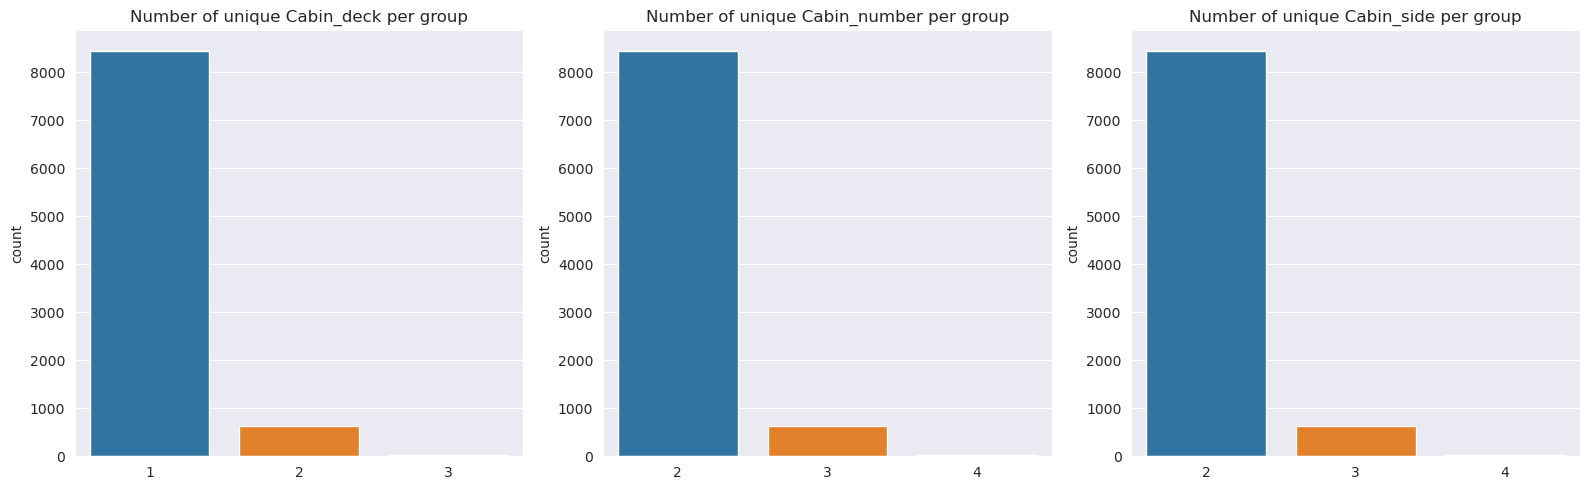

In [37]:
# joint distribution of group and cabin deck
GCD_gb = total.groupby(['Group','Cabin_deck']).size().unstack().fillna(0)
GCD_gb['Sum'] = (GCD_gb>0).sum(axis=1)

# joint distribution of group and cabin number
GCN_gb = total.groupby(['Group','Cabin_number']).size().unstack().fillna(0)
GCN_gb['Sum'] = (GCD_gb>0).sum(axis=1)

# joint distribution of group and cabin side
GCS_gb = total.groupby(['Group','Cabin_side']).size().unstack().fillna(0)
GCS_gb['Sum'] = (GCD_gb>0).sum(axis=1)

fig = plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.barplot( data=GCD_gb, x = GCD_gb['Sum'].value_counts().index,y=GCD_gb['Sum'].value_counts())
plt.ylabel('count')
plt.title('Number of unique Cabin_deck per group')

plt.subplot(1,3,2)
sns.barplot( data=GCN_gb, x = GCN_gb['Sum'].value_counts().index,y=GCN_gb['Sum'].value_counts())
plt.ylabel('count')
plt.title('Number of unique Cabin_number per group')

plt.subplot(1,3,3)
sns.barplot( data=GCS_gb, x = GCS_gb['Sum'].value_counts().index,y=GCS_gb['Sum'].value_counts())
plt.ylabel('count')
plt.title('Number of unique Cabin_side per group')

fig.tight_layout()
plt.show()

GCD_gb.drop('Sum',axis=1,inplace=True)
GCN_gb.drop('Sum',axis=1,inplace=True)
GCS_gb.drop('Sum',axis=1,inplace=True)

In all the 3 cases there is fairly good (but not perfect) coorelation with group

In [38]:
# filling missing values in Cabin side

CS_bef = total['Cabin_side'].isna().sum()

GCS_index = total[total['Cabin_side'].isna() & total['Group'].isin(GCS_gb.index)].index

total.loc[GCS_index,'Cabin_side'] = total.loc[GCS_index,'Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x] if x in GCS_gb.index else np.nan)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',total['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


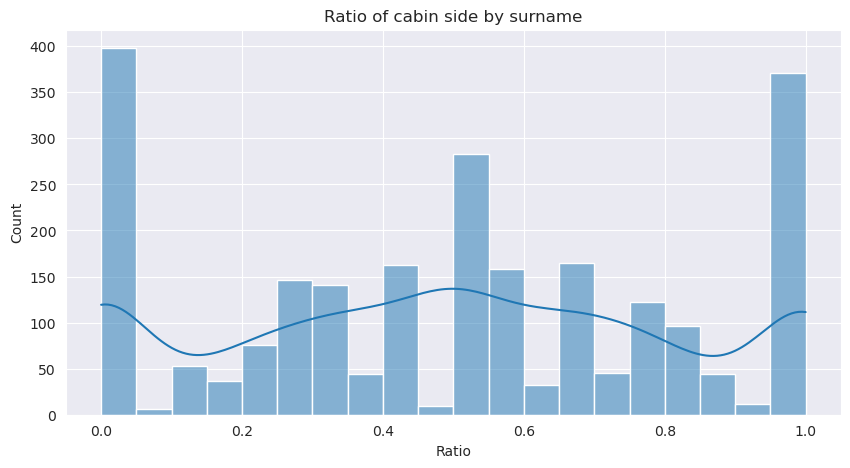

In [39]:
# joint distribution of surname and cabin side
SCS_gb = total.groupby(['Surname','Cabin_side']).size().unstack().fillna(0)

# Ratio of sides(P/[P+S])
SCS_gb['Ratio'] = SCS_gb['P'] / (SCS_gb['P'] + SCS_gb['S'])

# histogram of ratio
plt.figure(figsize=(10,5))
sns.histplot(SCS_gb['Ratio'],kde=True,binwidth=0.05)
plt.title('Ratio of cabin side by surname')
plt.show()

In [40]:
# let's see the percentage of families which are on the same side(either 0 or 1)
same_side_percent = np.round(SCS_gb['Ratio'].isin([0,1]).sum()/len(SCS_gb)*100,2)

print('Percent of families on same cabin side :',same_side_percent)

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

Percent of families on same cabin side : 32.03


In [41]:
# filling cabin side with help of surname
CS_bef = total['Cabin_side'].isna().sum()

SCS_index = total[total['Cabin_side'].isna() & total['Surname'].isin(SCS_gb.index)].index

total.loc[SCS_index,'Cabin_side'] = total.loc[SCS_index,'Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x] if x in SCS_gb.index else np.nan)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',total['Cabin_side'].isna().sum())

#Cabin_side missing values before: 162
#Cabin_side missing values after: 7


In [42]:
total['Cabin_side'].value_counts()

S    6532
P    6431
Name: Cabin_side, dtype: int64

Filling remaining values with outlier because we don't know which of the two side we should align

In [43]:
# Missing values before
CS_bef=total['Cabin_side'].isna().sum()

# Fill remaining missing values with outlier
total.loc[total['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',total['Cabin_side'].isna().sum())

#Cabin_side missing values before: 7
#Cabin_side missing values after: 0


In [44]:
CD_bef = total['Cabin_deck'].isna().sum()

# we made GCD_gb(joint distribution of cabin deck and group) before
GCD_index = total[total['Cabin_deck'].isna() & total['Group'].isin(GCD_gb.index)].index

total.loc[GCD_index,'Cabin_deck'] = total.loc[GCD_index,'Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x] if x in GCD_gb.index else np.nan)

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',total['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


In [45]:
# Home Planet , Destination, Solo and Cabin Deck joint distribution
HDSCD_gb = total.groupby(['HomePlanet','Destination','Solo','Cabin_deck']).size().unstack().fillna(0)
HDSCD_gb

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   48.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   263.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  134.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      97.0  376.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   33.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   87.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    20.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  170.0  220.0   795.0   
                         1       0.0    0.0    0.0  161.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1074.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

* Passengers from Earth are most likely on deck G  
* Passengers from Europa are most likely on deck B and C
* Passengers from Mars are most likely on deck F 

In [46]:
# Identify rows with missing Cabin_deck values
missing_rows = total['Cabin_deck'].isna()

# Group data by specified columns and calculate mode
grouped_mode = total.groupby(['HomePlanet', 'Destination', 'Solo'])['Cabin_deck'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Fill missing values using grouped mode
for index, row in total[missing_rows].iterrows():
    total.at[index, 'Cabin_deck'] = grouped_mode.get((row['HomePlanet'], row['Destination'], row['Solo']))

# Print the count of missing values before and after
CD_bef = missing_rows.sum()
CD_after = total['Cabin_deck'].isna().sum()
print('#Cabin_deck missing values before:', CD_bef)
print('#Cabin_deck missing values after:', CD_after)

#Cabin_deck missing values before: 162
#Cabin_deck missing values after: 0


### Cabin number

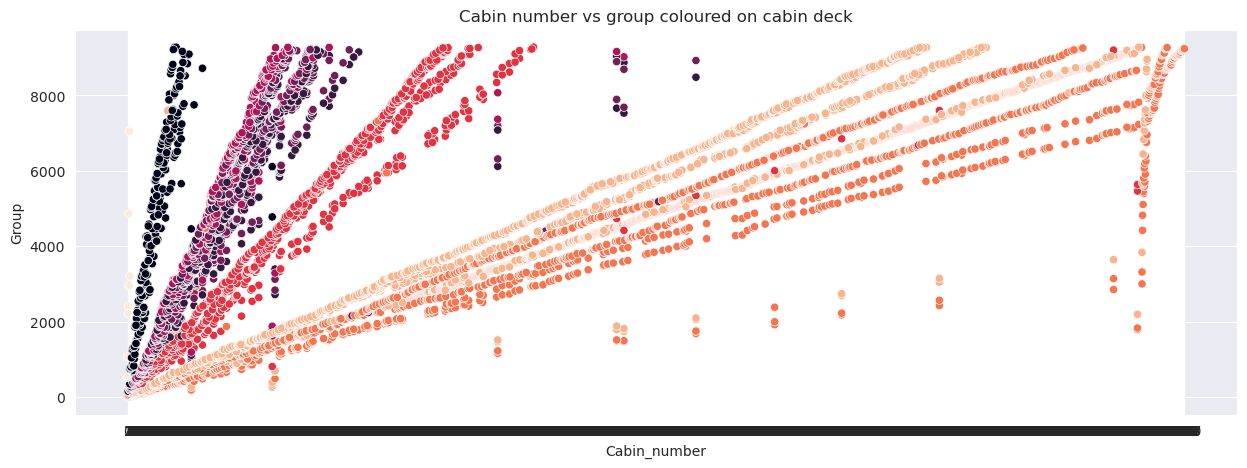

In [47]:
# cabin number and group(coloured on basis of cabin deck)
plt.figure(figsize=(15,5))
ax = sns.scatterplot(data=total , x='Cabin_number', y='Group', c=LabelEncoder().fit_transform(total.loc[~total['Cabin_number'].isna(),'Cabin_deck']))
plt.title('Cabin number vs group coloured on cabin deck')
plt.show()

The cabin number shows linear relationship with group on deck basis. We can use Linear regression on a deck by deck basis to fill in the missing values in cabin number

In [48]:
# Missing values before
CN_bef=total['Cabin_number'].isna().sum()

for deck in ['A','B','C','D','E','F','G']:
    #feature -> Group
    X_train_CN = total.loc[~(total['Cabin_number'].isna()) & (total['Cabin_deck'] == deck),'Group']
    #label -> predict cabin number 
    y_train_CN = total.loc[~(total['Cabin_number'].isna()) & (total['Cabin_deck'] == deck),'Cabin_number']
    #test
    X_test_CN = total.loc[(total['Cabin_number'].isna()) & (total['Cabin_deck'] == deck),'Group']
    
    # linear regression
    lr = LinearRegression()
    lr.fit(X_train_CN.values.reshape(-1,1),y_train_CN)
    pred_CN = lr.predict(X_test_CN.values.reshape(-1,1))
    
    # filling missing values with predictions
    total.loc[(total['Cabin_number'].isna()) & (total['Cabin_deck'] == deck), 'Cabin_number'] = pred_CN.astype(int)
    
# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',total['Cabin_number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


### VIP

In [49]:
# vip is highly imbalanced binary feature so we'll impute the mode
total.VIP.value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [50]:
# Missing values before
V_bef=total['VIP'].isna().sum()

# Fill missing values with mode
total.loc[total['VIP'].isna(),'VIP']=False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',total['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


### Age

Age varies across many features like HomePlanet, group size, expenditure and cabin deck, so we will impute missing values according to the median of these subgroups.

In [51]:
#  Joint distribution
total.groupby(['HomePlanet','no_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet no_spending Solo                                                
Earth      0           0      0.0   0.0  31.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0  26.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0  16.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0  42.5   0.0  21.0  23.0  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  35.0  30.0  29.0  44.0
                       1     35.0  36.0  35.0  34.0  34.5  45.5  31.0  35.0
           1           0     30.0  27.0  29.0  26.5  28.0  50.0  25.0   0.0
                       1     37.0  34.0  35.0  32.0  33.0  29.5  32.5   0.0
Mars       0           0      0.0   0.0  41.0  30.0  29.0  29.0  21.0   0.0
                       1      0.0   0.0   0.0  32.0  29.0  30.0  26.0   0.0
           1           0      0.0   0.0   0.0  29.0  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  30.0  29.0  39.5   0.0

In [52]:
# Identify rows with missing Cabin_deck values
missing_rows = total['Age'].isna()

# Group data by specified columns and calculate mode
grouped_mode = total.groupby(['HomePlanet','no_spending','Solo','Cabin_deck'])['Age'].apply(lambda x: x.median())

# Fill missing values using grouped mode
for index, row in total[missing_rows].iterrows():
    total.at[index, 'Age'] = grouped_mode.get((row['HomePlanet'], row['no_spending'], row['Solo'] , row['Cabin_deck']))

# Print the count of missing values before and after
Age_bef = missing_rows.sum()
Age_after = total['Age'].isna().sum()
print('#Age missing values before:', Age_bef)
print('#Age missing values after:', Age_after)

#Age missing values before: 270
#Age missing values after: 0


In [53]:
# update the age group feature using the new data
total.loc[(total['Age']<=18),'Age_group'] = 'Age_0-18'
total.loc[(total['Age']>18) & (total['Age']<=30),'Age_group'] = 'Age_19-30'
total.loc[(total['Age']>30) & (total['Age']<=50),'Age_group'] = 'Age_31-50'
total.loc[(total['Age']>50),'Age_group'] = 'Age_51+'

### CryoSleep

In [54]:
# If a passenger is in cryosleep then he/she has not spent anything (Expenditure = 0)
total.groupby(['no_spending','CryoSleep']).size().unstack().fillna(0)

CryoSleep,False,True
no_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [55]:
# Identify rows with missing Cabin_deck values
missing_rows = total['CryoSleep'].isna()

# Group data by specified columns and calculate mode
grouped_mode = total.groupby(['no_spending'])['CryoSleep'].apply(lambda x: x.mode()[0])

# Fill missing values using grouped mode
for index, row in total[missing_rows].iterrows():
    total.at[index, 'CryoSleep'] = grouped_mode.get((row['no_spending']))

# Print the count of missing values before and after
CS_bef = missing_rows.sum()
CS_after = total['CryoSleep'].isna().sum()
print('#Age missing values before:', CS_bef)
print('#Age missing values after:', CS_after)

#Age missing values before: 310
#Age missing values after: 0


### Expenditure features

People in cryosleep has 0 Expenditure.

In [56]:
exp_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

# Missing values before
E_bef=total[exp_features].isna().sum().sum()

for col in exp_features:
    total.loc[(total[col].isna()) & (total['CryoSleep'] == True),col] = 0
    
# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',total[exp_features].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 863


Expenditure and other features
* Expenditure varies across many features but we will only impute missing values using HomePlanet, Solo and Age group to prevent overfitting. We will also use the mean instead of the median because a large proportion of passengers don't spend anything and median usually comes out as 0.

In [57]:
total.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group           Age_0-18    Age_19-30    Age_31-50      Age_51+
HomePlanet Solo                                                    
Earth      0      195.246777   804.186047   737.041943   739.974138
           1      635.003394   790.765702   796.056281   874.953560
Europa     0     1068.363296  3166.028721  3978.887574  3535.987234
           1     2284.400000  3361.465714  3919.835106  3829.306122
Mars       0      503.491184  1209.402083  1144.643979  1336.809091
           1     1321.821705  1060.877250  1118.737958  1096.319672

In [58]:
# Identify rows with missing Cabin_deck values
E_bef=total[exp_features].isna().sum().sum()

# Group data by specified columns and calculate mode
grouped_mode = total.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].apply(lambda x: x.mean())

# Fill missing values using grouped mode
for col in exp_features:
    missing_rows = total[col].isna()
    for index, row in total[missing_rows].iterrows():
        total.at[index, col] = grouped_mode.get((row['HomePlanet'], row['Solo'], row['Age_group']))

# Print the count of missing values before and after
CS_after = total[exp_features].isna().sum().sum()
print('#All Expenditure features missing values before:', E_bef)
print('#All Expenditure featues missing values after:', CS_after)

#All Expenditure features missing values before: 863
#All Expenditure featues missing values after: 0


In [59]:
# update Expenditure and No Spending feature with new data
total['Expenditure'] = total[exp_features].sum(axis=1)
total['no_spending'] = (total['Expenditure']==0).astype(int)

In [60]:
total.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           299
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            294
Group             0
Group_size        0
Solo              0
Cabin_deck        0
Cabin_number      0
Cabin_side        0
Age_group         0
Expenditure       0
no_spending       0
Surname         155
Family_size       0
dtype: int64

## Preprocessing

In [61]:
# Train and test
train=total[total['PassengerId'].isin(train['PassengerId'])].copy()
test=total[total['PassengerId'].isin(test['PassengerId'])].copy()

print(train.shape , test.shape)

(8693, 24) (4277, 24)


In [62]:
# Drop qualitative/redundant/collinear/high cardinality features
train.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number','Cabin','Surname','Name'], axis=1, inplace=True)
test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number','Cabin','Surname','Name'], axis=1, inplace=True)

#### Log transform

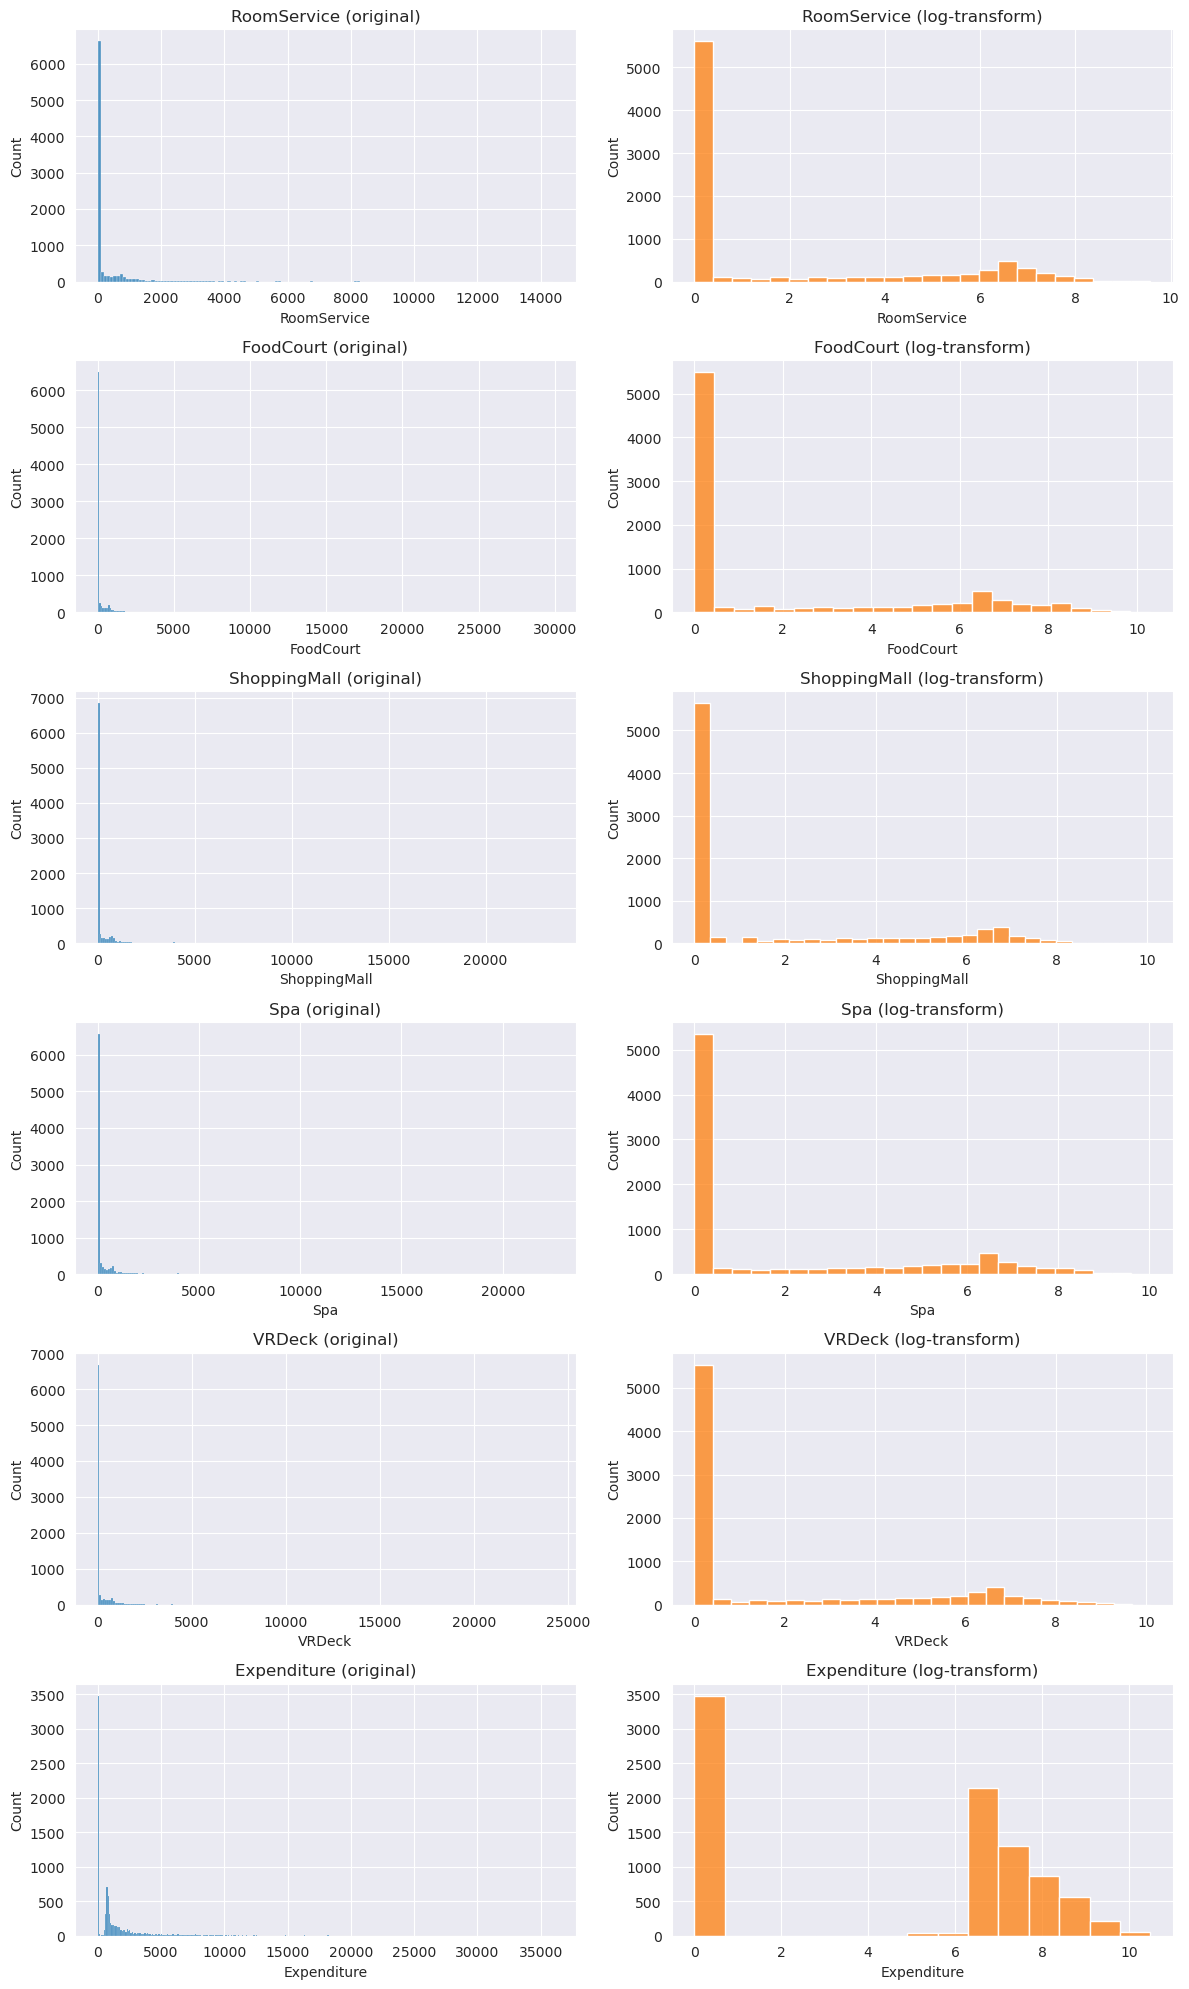

In [63]:
#  Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(train[col], binwidth=100)
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+train[col]), color='C1')
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [64]:
# Apply log transform
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    train[col]=np.log(1+train[col])
    test[col]=np.log(1+test[col])

In [65]:
# Indentify numerical and categorical columns
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in train.columns if train[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse_output=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
train = ct.fit_transform(train)
test = ct.transform(test)

# Print new shape
print('Training set shape:', train.shape)

Training set shape: (8693, 29)


In [66]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(train,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [67]:
# models

# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    #"XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

Train models with grid search (but no cross validation so it doesn't take too long) to get a rough idea of which are the best models for this dataset.

In [68]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Model: LogisticRegression
Training time (mins): 0.08

Model: KNN
Training time (mins): 0.1

Model: SVC
Training time (mins): 15.75

Model: RandomForest
Training time (mins): 3.13

Model: LGBM
Training time (mins): 2.32

Model: CatBoost
Training time (mins): 9.19

Model: NaiveBayes
Training time (mins): 0.0



In [69]:
# Show results
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.768833,0.08
1,KNN,0.761357,0.10
2,SVC,0.792409,15.75
3,RandomForest,0.792409,3.13
4,LGBM,0.800460,2.32
5,CatBoost,0.806210,9.19
6,NaiveBayes,0.569868,0.00


LGBM and CatBoost performed good than others. So , we'll only take these two and move forward.

In [70]:
# Show best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 0.25, 'max_iter': 100, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 1},
 'SVC': {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 10, 'n_estimators': 300},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150},
 'CatBoost': {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 150},
 'NaiveBayes': {'var_smoothing': 1e-07}}

Define best models with best hyper parameters

In [71]:
# Classifiers
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=0),
}

Predictions are ensembled together using soft voting. This averages the predicted probabilies to produce the most confident predictions.

In [72]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(train, y)):
        # Get training and validation sets
        X_train, X_valid = train[train_idx], train[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(test)[:,1]
        score += clf.score(X_valid, y_valid)
        
    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

Model: LGBM
Average validation accuracy: 80.34
Training time (mins): 0.1

Model: CatBoost
Average validation accuracy: 80.64
Training time (mins): 0.13



Text(0.5, 0, 'Probability')

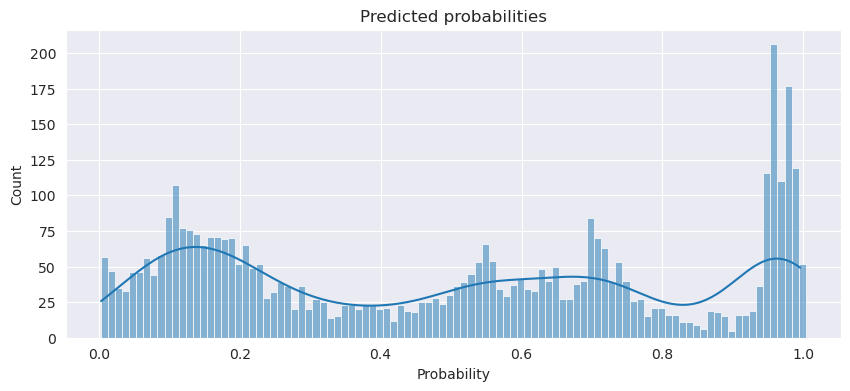

In [73]:
# Let's look at the distribution of the predicted probabilities.

plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

Finally, we need to convert each predicted probability into one of the two classes (transported or not). The simplest way is to round each probability to the nearest integer (0 for False or 1 for True). However, assuming the train and test sets have similar distributions, we can tune the classification threshold to obtain a similar proportion of transported/not transported in our predictions as in the train set. Remember that the proportion of transported passengers in the train set was 50.4%.

In [74]:
# Proportion (in test set) we get from rounding
print(np.round(100*np.round(preds).sum()/len(preds),2))

52.19


Our models seem to (potentially) overestimate the number of transported passengers in the test set. Let's try to bring that proportion down a bit.

Optimal threshold: 0.504


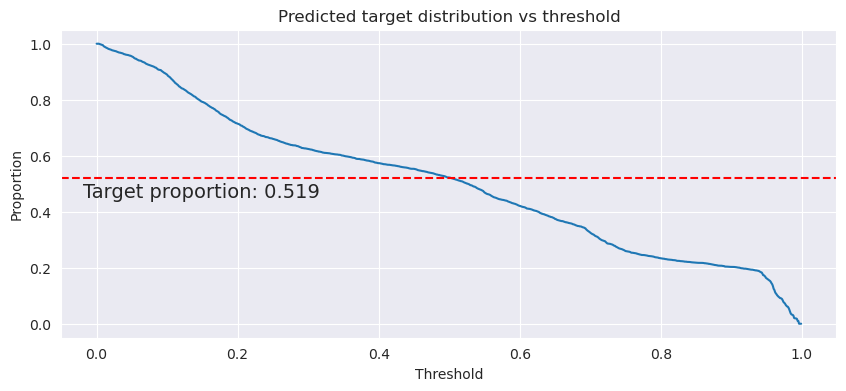

In [75]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions one by one 
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.519         # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

In [76]:
# Classify test set using optimal threshold
preds_tuned=(preds>=T_opt).astype(int)

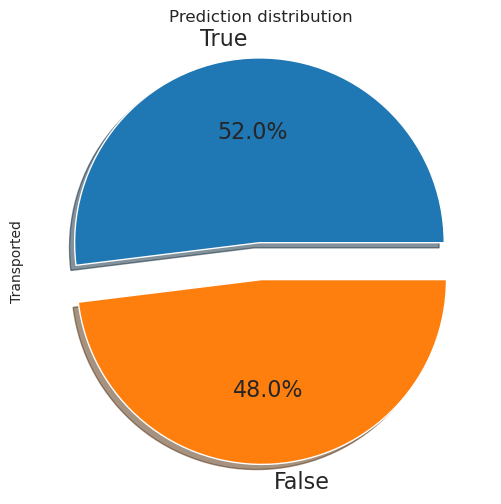

In [77]:
# Sample submission (to get right format)
sub=pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

# Add predictions
sub['Transported']=preds_tuned

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")
plt.show()

In [78]:
# Output to csv
sub.to_csv('submission.csv', index=False)